In [28]:
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [29]:
df = pd.read_excel("msga-order.xlsx")

In [30]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [31]:
df['InvoiceYearMonth'] = df['OrderDate'].map(lambda date: 100*date.year + date.month)

In [32]:
df.describe()

,MobileNo,Qty,PartMRP,AmountPaid,TotalBillingAmount,InvoiceYearMonth
count,1.187100e+04,11870.000000,11870.000000,11870.000000,11870.000000,11871.000000
mean,9.168008e+09,1.404212,977.666049,1754.794777,2738.335973,202206.628085
std,8.725163e+08,1.424678,1468.533521,3124.507362,4608.503687,1.107491
min,6.000567e+09,1.000000,3.000000,0.000000,3.000000,202205.000000
25%,8.754558e+09,1.000000,250.000000,160.000000,965.500000,202206.000000
50%,9.535928e+09,1.000000,490.000000,1047.000000,1450.000000,202207.000000
75%,9.845510e+09,1.000000,1290.000000,1950.000000,2690.000000,202208.000000
max,1.000000e+10,30.000000,42990.000000,56170.000000,56170.000000,202208.000000


In [39]:
df=df.dropna()
df1 = df.drop_duplicates(subset = ["MobileNo"])
df1

df['MobileNo'] = df['MobileNo'].astype('int64') 
df


,Web_Order_ID,MobileNo,OrderDate,OrderNo,EnqNo,EmailId,CustomerName,Address1,Address2,Address3,Location,State,PartNo,Qty,PartMRP,AmountPaid,TotalBillingAmount,InvoiceYearMonth
0,WMA220501001925,9884887073,2022-05-01 00:19:25.967,AOD22000006,ACC22000010,gbabu88@gmail.com,Ganesh Babu,62B,"Annai Velankanni Nagar Phase 2, Mugalivakkam",Next to Shakthi Super Market,CHENNAI,TAMIL NADU,990J0M55R02-020,1.0,1090.0,870.0,1090.0,202205.0
1,WMA220501011241,9419738830,2022-05-01 01:12:41.837,AOD22000001,ACC22000002,manishsabraj@gmail.com,Manish Sabraj,Quarter No 3,Manu Marg,SMVD UNIVERSITY Katra,JAMMU,JAMMU AND KASHMIR,990J0M81RA3-010,1.0,1390.0,0.0,1390.0,202205.0
2,WMA220501013210,9035570879,2022-05-01 01:32:10.917,AOD22000009,ACC22000020,dsk275@outlook.com,Shashikiran D,"House No. 275, First Main, White City Layout,","Seegehalli, Krishanarajapuram, Bangalore",Next to VITALS Hospital / Diagnostics,BANGALORE,KARNATAKA,75901M65MF0,1.0,2288.0,1711.0,2288.0,202205.0
3,WMA220501013819,9035570879,2022-05-01 01:38:19.627,AOD22000003,ACC22000009,dsk275@outlook.com,Shashikiran D,"House No. 275, First Main, White City Layout,","Seegehalli, Krishanarajapuram, Bangalore",Next to VITALS Hospital / Diagnostics,BANGALORE,KARNATAKA,990J0M65MU0-010,1.0,1315.0,1315.0,1315.0,202205.0
4,WMA220501062333,8801444525,2022-05-01 06:23:33.897,AOD22000009,ACC22000012,snmohtada@gmail.com,Syed Mohtada,16-10-48/B,New Malakpet,Nalgonda X Road Flyover Bridge,HYDERABAD,TELANGANA,990J0M82P13-210,1.0,699.0,0.0,1798.0,202205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,WMA220831222349,7994330730,2022-08-31 22:23:49.527,AOD22000019,ACC22000030,ktabdulnasar1959@gmail.com,Abdul Nasar K T,"Sana House, Karanthat","Po Karanthat, Kunnaru, Via) Ramanthali",Near Kunnaru AUP School,KANNUR,KERALA,990J0M66T13-090,1.0,290.0,0.0,290.0,202208.0
11867,WMA220831223516,9811829429,2022-08-31 22:35:16.750,AOD22000049,ACC22000093,Santhoshnva0004@gmail.com,Mullu siva santhosh Kumar,"House no 92 , first floor",Sector 10,Behind civil hospital,GURGAON,HARYANA,990J0M72RA3-010,1.0,350.0,350.0,350.0,202208.0
11868,WMA220831223630,8800066069,2022-08-31 22:36:30.653,AOD22000056,ACC22000072,harshitmohan29@gmail.com,Harshit Mohan,A 170,Govindpuram Near Lg showroom,Ghaziabad,GHAZIABAD,UTTAR PRADESH,990J0M999L1-440,1.0,550.0,827.0,1799.0,202208.0
11869,WMA220831223630,8800066069,2022-08-31 22:36:30.653,AOD22000056,ACC22000072,harshitmohan29@gmail.com,Harshit Mohan,A 170,Govindpuram Near Lg showroom,Ghaziabad,GHAZIABAD,UTTAR PRADESH,990J0M99911-110,1.0,1249.0,827.0,1799.0,202208.0


In [40]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(df['MobileNo'].unique())
tx_user.columns = ['MobileNo']
tx_user.head()


,MobileNo
0,9884887073
1,9419738830
2,9035570879
3,8801444525
4,9958870078


In [41]:
tx_max_purchase = df.groupby('MobileNo').OrderDate.max().reset_index()
tx_max_purchase.columns = ['MobileNo','MaxPurchaseDate']
tx_max_purchase.head()

,MobileNo,MaxPurchaseDate
0,6000567125,2022-08-28 19:52:31.870
1,6005564227,2022-05-21 12:21:58.167
2,6200284850,2022-07-08 20:16:07.030
3,6238130185,2022-06-16 21:29:24.163
4,6238133938,2022-08-20 19:16:25.297


In [42]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,MobileNo,MaxPurchaseDate,Recency
0,6000567125,2022-08-28 19:52:31.870,3
1,6005564227,2022-05-21 12:21:58.167,102
2,6200284850,2022-07-08 20:16:07.030,54
3,6238130185,2022-06-16 21:29:24.163,76
4,6238133938,2022-08-20 19:16:25.297,11


In [43]:
tx_user = pd.merge(tx_user, tx_max_purchase[['MobileNo','Recency']], on='MobileNo')
tx_user.tail(23)

,MobileNo,Recency
4861,9819695093,0
4862,9844929965,0
4863,9812079283,0
4864,9900321202,0
4865,9567401068,0
4866,8711047085,0
4867,9962856780,0
4868,8080661001,0
4869,9611868913,0
4870,9497689501,0


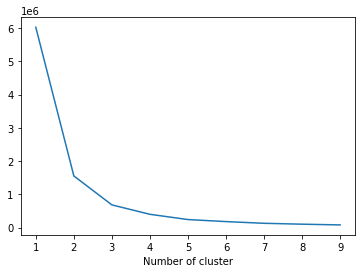

In [44]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [45]:
kmeans = KMeans(n_clusters=4)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']])

In [46]:
tx_user.head()

,MobileNo,Recency,RecencyCluster
0,9884887073,122,1
1,9419738830,122,1
2,9035570879,122,1
3,8801444525,122,1
4,9958870078,122,1


In [47]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1182.0,11.313029,7.396716,0.0,5.0,11.0,18.0,24.0
1,1124.0,104.330961,10.133257,88.0,96.0,104.0,113.0,122.0
2,1394.0,70.383788,9.568196,55.0,62.0,70.0,79.0,87.0
3,1184.0,38.644426,8.688334,25.0,31.0,38.0,46.0,54.0


In [48]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [61]:
tx_user.tail(23)

,MobileNo,Recency,RecencyCluster,Frequency,FrequencyCluster
4861,9029800800,34,2,10,2
4862,9311111134,35,2,10,2
4863,9947783723,34,2,9,2
4864,9910120435,33,2,6,2
4865,9766826853,32,2,6,2
4866,9989096060,32,2,6,2
4867,7710053059,30,2,6,2
4868,9980065019,29,2,8,2
4869,9923633363,29,2,6,2
4870,8233366222,29,2,7,2


In [50]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1124.0,104.330961,10.133257,88.0,96.0,104.0,113.0,122.0
1,1394.0,70.383788,9.568196,55.0,62.0,70.0,79.0,87.0
2,1184.0,38.644426,8.688334,25.0,31.0,38.0,46.0,54.0
3,1182.0,11.313029,7.396716,0.0,5.0,11.0,18.0,24.0


In [52]:
tx_frequency = df.groupby('MobileNo').OrderDate.count().reset_index()
tx_frequency.columns = ['MobileNo','Frequency']

In [53]:
tx_frequency.head()

,MobileNo,Frequency
0,6000567125,1
1,6005564227,1
2,6200284850,2
3,6238130185,1
4,6238133938,3


In [55]:
tx_user = pd.merge(tx_user, tx_frequency, on='MobileNo')

tx_user.head()

,MobileNo,Recency,RecencyCluster,Frequency
0,9884887073,122,0,1
1,9419738830,122,0,1
2,9035570879,122,0,2
3,8801444525,122,0,3
4,9958870078,122,0,2


C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\3933421856.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\3933421856.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\3933421856.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

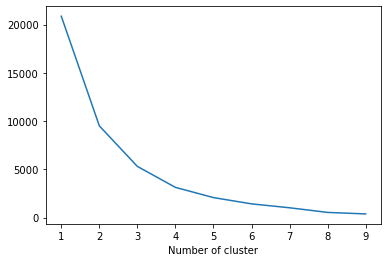

In [56]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [57]:
kmeans=KMeans(n_clusters=4)
tx_user['FrequencyCluster']=kmeans.fit_predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True )
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3779.0,1.210638,0.407816,1.0,1.0,1.0,1.0,2.0
1,855.0,3.657310,0.776252,3.0,3.0,3.0,4.0,5.0
2,243.0,7.654321,2.249851,6.0,6.0,7.0,8.0,17.0
3,7.0,30.000000,9.469248,21.0,23.0,26.0,36.5,44.0


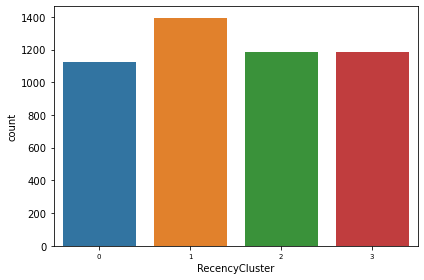

In [58]:
tx_user
ax = sns.countplot(x="RecencyCluster", data=tx_user)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

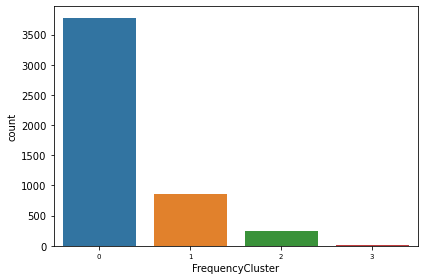

In [59]:
tx_user
ax = sns.countplot(x="FrequencyCluster", data=tx_user)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

In [62]:
monetary = df.groupby('MobileNo')['TotalBillingAmount'].sum()
monetary = monetary.reset_index()
monetary.tail()

,MobileNo,TotalBillingAmount
4879,9999988328,6276.0
4880,9999990345,1130.0
4881,9999997468,2111.0
4882,9999998651,11652.0
4883,9999999999,425.0


In [63]:
tx_user = pd.merge(tx_user, monetary, on='MobileNo')

tx_user.head()

,MobileNo,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalBillingAmount
0,9884887073,122,0,1,0,1090.0
1,9419738830,122,0,1,0,1390.0
2,9035570879,122,0,2,0,3603.0
3,9958870078,122,0,2,0,2140.0
4,9426824801,122,0,1,0,1390.0


C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\2711129186.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\2711129186.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\2711129186.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

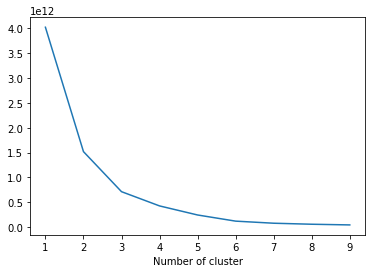

In [65]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['TotalBillingAmount']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [66]:
kmeans=KMeans(n_clusters=4)
tx_user['monetarycluster']=kmeans.fit_predict(tx_user[['TotalBillingAmount']])

#order the frequency cluster
tx_user = order_cluster('monetarycluster', 'TotalBillingAmount', tx_user, True )
tx_user.groupby('monetarycluster')['TotalBillingAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
monetarycluster,,,,,,,,
0,4767.0,3.251778e+03,4665.648120,5.0,790.00,1499.0,3550.00,31680.0
1,108.0,6.076022e+04,33243.026509,32320.0,38148.00,49464.0,64046.75,176520.0
2,7.0,3.309080e+05,57217.866708,252160.0,293826.00,337020.0,367466.00,404592.0
3,2.0,1.124478e+06,427424.128917,822244.0,973361.25,1124478.5,1275595.75,1426713.0


In [67]:
tx_user

,MobileNo,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalBillingAmount,monetarycluster
0,9884887073,122,0,1,0,1090.0,0
1,9419738830,122,0,1,0,1390.0,0
2,9035570879,122,0,2,0,3603.0,0
3,9958870078,122,0,2,0,2140.0,0
4,9426824801,122,0,1,0,1390.0,0
...,...,...,...,...,...,...,...
4879,9741412283,57,1,12,2,340222.0,2
4880,9832387776,55,1,16,2,270720.0,2
4881,8763595874,45,2,24,3,404592.0,2
4882,9945479149,2,3,31,3,822244.0,3


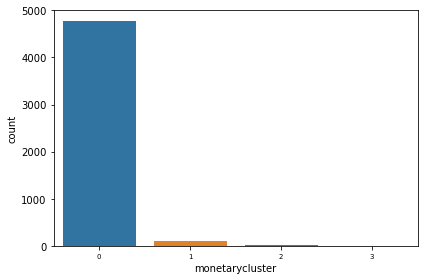

In [68]:
tx_user
ax = sns.countplot(x="monetarycluster", data=tx_user)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

In [76]:
tx_user[tx_user.monetarycluster==2].count()


MobileNo              7
Recency               7
RecencyCluster        7
Frequency             7
FrequencyCluster      7
TotalBillingAmount    7
monetarycluster       7
dtype: int64

In [78]:

quantiles = tx_user.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()


In [79]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [82]:
tx_user['R'] = tx_user['Recency'].apply(RScore, args=('Recency',quantiles))
tx_user['F'] = tx_user['Frequency'].apply(FMScore, args=('Frequency',quantiles))
tx_user['M'] = tx_user['TotalBillingAmount'].apply(FMScore, args=('TotalBillingAmount',quantiles))
tx_user.head()

,MobileNo,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalBillingAmount,monetarycluster,R,F,M
0,9884887073,122,0,1,0,1090.0,0,4,4,3
1,9419738830,122,0,1,0,1390.0,0,4,4,3
2,9035570879,122,0,2,0,3603.0,0,4,2,2
3,9958870078,122,0,2,0,2140.0,0,4,2,2
4,9426824801,122,0,1,0,1390.0,0,4,4,3


In [83]:
tx_user['RFM_score'] = tx_user.M*(tx_user.F*(1+120/tx_user.R))
tx_user.head(20)


,MobileNo,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalBillingAmount,monetarycluster,R,F,M,RFM_score
0,9884887073,122,0,1,0,1090.0,0,4,4,3,372.0
1,9419738830,122,0,1,0,1390.0,0,4,4,3,372.0
2,9035570879,122,0,2,0,3603.0,0,4,2,2,124.0
3,9958870078,122,0,2,0,2140.0,0,4,2,2,124.0
4,9426824801,122,0,1,0,1390.0,0,4,4,3,372.0
5,6901226572,122,0,1,0,1490.0,0,4,4,3,372.0
6,9008519689,122,0,1,0,63.0,0,4,4,4,496.0
7,9897679670,122,0,1,0,1200.0,0,4,4,3,372.0
8,9791508602,122,0,2,0,5078.0,0,4,2,1,62.0
9,9538221522,122,0,2,0,1570.0,0,4,2,3,186.0


C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\1190029163.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\1190029163.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AGL\AppData\Local\Temp\ipykernel_11600\1190029163.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

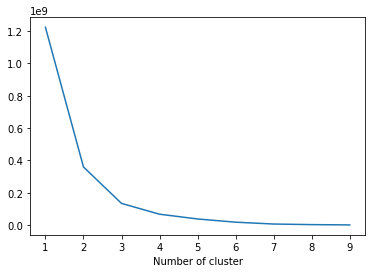

In [84]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['RFM_score']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [86]:
kmeans=KMeans(n_clusters=4)
tx_user['RFM_cluster']=kmeans.fit_predict(tx_user[['RFM_score']])

#order the frequency cluster
tx_user = order_cluster('RFM_cluster', 'RFM_score', tx_user, True )
tx_user.groupby('RFM_cluster')['RFM_score'].describe()
 

,count,mean,std,min,25%,50%,75%,max
RFM_cluster,,,,,,,,
0,1917.0,126.129369,77.069255,31.0,61.0,121.0,186.0,248.0
1,1422.0,440.103376,66.084872,328.0,372.0,488.0,492.0,496.0
2,1029.0,815.959184,142.043406,656.0,656.0,732.0,976.0,976.0
3,516.0,1733.395349,239.003576,1452.0,1452.0,1936.0,1936.0,1936.0


In [1]:
tx_user.head(23)

NameError: name 'tx_user' is not defined

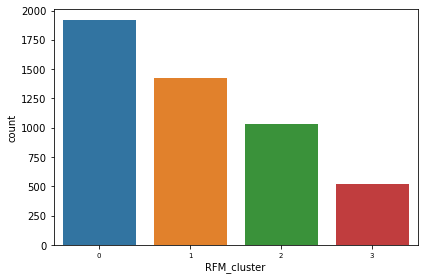

In [88]:
tx_user
ax = sns.countplot(x="RFM_cluster", data=tx_user)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()